## Preliminary Steps

### Import the necessary modules

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import datetime
import calendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, roc_curve
from matplotlib.ticker import FuncFormatter

### Import the Fraud Detection dataset

In [254]:
with zipfile.ZipFile('fraud_detection.zip') as z1:
    with z1.open('Fraud_Data.csv') as Fraud_Data:
        fraud_data = pd.read_csv(Fraud_Data)
    with z1.open('IpAddress_to_Country.csv') as IpAddress_to_Country:
        ip_table = pd.read_csv(IpAddress_to_Country)

## Exploratory Data Analysis

### Explore the Fraud data

In [255]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [256]:
# The proportion of fraud in this dataset (as measured by the 'class' column) is 9.36%

fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [257]:
# Only user_id and signup_time have all unique values

fraud_data.nunique().sort_values()

sex                    2
class                  2
source                 3
browser                5
age                   58
purchase_value       122
device_id         137956
ip_address        143512
purchase_time     150679
user_id           151112
signup_time       151112
dtype: int64

In [258]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [259]:
numerical_features = list(fraud_data.select_dtypes('number'))
categorical_features = list(fraud_data.select_dtypes('object'))

print(f'Numerical Columns: \n{numerical_features}\n')
print(f'Numerical Columns: \n{categorical_features}')

Numerical Columns: 
['user_id', 'purchase_value', 'age', 'ip_address', 'class']

Numerical Columns: 
['signup_time', 'purchase_time', 'device_id', 'source', 'browser', 'sex']


In [260]:
# Each row in the fraud dataset has a unique user_id

# fraud_data.user_id.value_counts()

In [261]:
# fraud_data.signup_time.value_counts()

In [262]:
# fraud_data.purchase_time.value_counts()

In [263]:
# fraud_data.purchase_value.value_counts()

In [264]:
# fraud_data.device_id.value_counts()

In [265]:
# fraud_data.source.value_counts()

In [266]:
# fraud_data.browser.value_counts()

In [267]:
# fraud_data.sex.value_counts()

In [268]:
# fraud_data.age.value_counts()

In [269]:
# fraud_data.ip_address.value_counts()

In [270]:
# fraud_data['class'].value_counts()

### Explore the IP Table data

In [271]:
ip_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [272]:
ip_table.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [273]:
ip_table.nunique().sort_values()

country                      235
lower_bound_ip_address    138846
upper_bound_ip_address    138846
dtype: int64

In [274]:
ip_table.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [275]:
# ip_table.lower_bound_ip_address.value_counts()

In [276]:
# ip_table.upper_bound_ip_address.value_counts()

In [277]:
# ip_table.country.value_counts()

## Feature Engineering

### Get the country related to each IP address

In [278]:
ip_table.upper_bound_ip_address.astype('float')
ip_table.lower_bound_ip_address.astype('float')
fraud_data.ip_address.astype('float')

0         7.327584e+08
1         3.503114e+08
2         2.621474e+09
3         3.840542e+09
4         4.155831e+08
              ...     
151107    3.451155e+09
151108    2.439047e+09
151109    2.748471e+09
151110    3.601175e+09
151111    4.103825e+09
Name: ip_address, Length: 151112, dtype: float64

In [279]:
# Create a function ip_to_country that takes an IP address as argument and returns the country associated based on the IP table

# Create a function normalize_company_names to clean records in the Make column

def ip_to_country(ip):
    '''Takes in an IP address, checks against the lower and upper bound ip address for each country in the IP table
        If the IP address falls within the range of a country, country name is returned.
        If the IP address does not fall within the range of any country, 'Unknown' is returned.
    '''
    try :
        return ip_table.country[(ip_table.lower_bound_ip_address < ip) & (ip_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return 'Unknown'   

### Add a country column related to each IP address

In [280]:
# Create a country column and find the country for each ip address using the ip_to_country function I created]:
fraud_data['country'] = fraud_data.ip_address.apply(ip_to_country)

In [281]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country         151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [282]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [283]:
# fraud_data.country.value_counts()

### Add a Countries from Device column that shows the count of countries in which a device made purchases

In [284]:
# Create a dataframe that counts the occurrence of each country by device ID 
country_count = fraud_data.groupby(['device_id','country'])['user_id'].count().reset_index()

# Count the number of different countries by device_id
country_count = pd.DataFrame(country_count.groupby('device_id').count().country)

# Merge the resulting country_count dataframe with the main fraud_data dataset 
fraud_data = fraud_data.merge(country_count, left_on='device_id', right_index=True)
fraud_data.rename(columns={'country_x': 'country' , 'country_y':'countries_from_device'}, inplace = True)


In [285]:
# fraud_data.countries_from_device.value_counts()

### Add a Country Risk column that classifies each country by the level of fraud risk

In [286]:
country_risk = pd.DataFrame(fraud_data.groupby('country')['class'].mean().sort_values(ascending = False))

country_risk['country_risk'] = country_risk['class'].apply(lambda x : 
                                                           'Very High risk' if x > 0.25 else
                                                           'High risk' if x > 0.05 else
                                                           'Medium risk' if x > 0.01 else
                                                           'Low risk')

fraud_data = fraud_data.merge(country_risk.drop('class', axis = 1), left_on= 'country', right_index = True)                                                           

In [287]:
# fraud_data.country_risk.value_counts()

### Add an Age Group column that indicates the age range of the purchaser

In [288]:
fraud_data['age_group'] = fraud_data.age.apply(lambda x : 
                 '< 40' if x < 40 else
                 '40 - 49' if x < 50 else
                 '50 - 59' if x < 60 else
                 '60 - 69' if x < 70 else
                 ' > 70')

In [289]:
# fraud_data.age_group.value_counts()

### Add a device frequency column related to the count of each device ID

In [290]:
fraud_data.groupby('device_id').device_id.count().sort_values(ascending=False)

device_id
KIPFSCNUGOLDP    20
NGQCKIADMZORL    20
CQTUVBYIWWWBC    20
ITUMJCKWEYNDD    20
EQYVNEGOFLAWK    20
                 ..
IXVBQLPWSAIDA     1
IXUYCZZVDXGPO     1
IXUWTGATQJEVG     1
IXUKDXQBVCYCZ     1
ZZZXASJUVUNMV     1
Name: device_id, Length: 137956, dtype: int64

In [291]:
device_freq = pd.DataFrame(fraud_data.groupby('device_id').device_id.count())

# Rename the count of device_id to device_freq so there is no duplicate column name
device_freq.rename(columns={'device_id': 'device_freq'}, inplace=True)

# Convert device_id from index to column so we can merge with the fraud_data dataset
device_freq.reset_index(level=0, inplace= True)

# Merge device_freq dataset with the fraud_data dataset
fraud_data = fraud_data.merge(device_freq, on= 'device_id')


In [292]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,countries_from_device,country_risk,age_group,device_freq
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,High risk,< 40,1
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,0,Japan,1,High risk,< 40,1
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,0,Japan,1,High risk,40 - 49,1
3,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,0,Japan,2,High risk,40 - 49,2
4,192767,2015-01-08 12:17:12,2015-04-28 02:09:42,15,ZTORJKTDMYTJH,Ads,Safari,M,32,2.568640e+09,0,United States,2,High risk,< 40,2


In [293]:
# fraud_data.device_freq.value_counts()

Text(0, 0.5, 'Distribution')

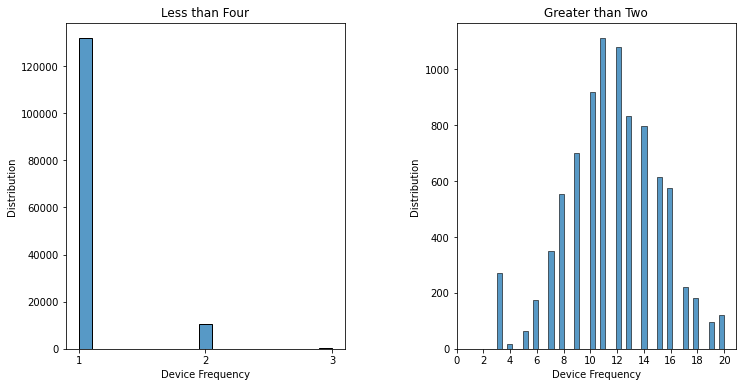

In [294]:
f, ax = plt.subplots(1,2,figsize=(12,6))
f.subplots_adjust(wspace=0.4)
g1 =sns.histplot(fraud_data.device_freq[fraud_data.device_freq <4], ax=ax[0])
g1.set(xticks=[1,2,3])
ax[0].set_title('Less than Four')
ax[0].set_xlabel('Device Frequency')
ax[0].set_ylabel('Distribution')

g2 =sns.histplot(fraud_data.device_freq[fraud_data.device_freq >2], ax=ax[1])
g2.set(xticks = range(0,21,2))
ax[1].set_title('Greater than Two')
ax[1].set_xlabel('Device Frequency')
ax[1].set_ylabel('Distribution')


### Add an IP address frequency column related to the count of each IP address

In [295]:
fraud_data.groupby('ip_address').ip_address.count().sort_values(ascending=False)

ip_address
1.502818e+09    20
5.760609e+08    20
3.874758e+09    20
2.050964e+09    20
2.937899e+09    19
                ..
1.427304e+09     1
1.427303e+09     1
1.427285e+09     1
1.427208e+09     1
4.294850e+09     1
Name: ip_address, Length: 143512, dtype: int64

In [296]:
ip_address_freq = pd.DataFrame(fraud_data.groupby('ip_address').ip_address.count())

# Rename the count of ip_address to ip_address_freq so there is no duplicate column name
ip_address_freq.rename(columns={'ip_address': 'ip_address_freq'}, inplace=True)

# Convert ip_address from index to column so we can merge with the fraud_data dataset
ip_address_freq.reset_index(level=0, inplace= True)

# Merge ip_address_freq dataset with the fraud_data dataset
fraud_data = fraud_data.merge(ip_address_freq, on= 'ip_address')

In [297]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,countries_from_device,country_risk,age_group,device_freq,ip_address_freq
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,High risk,< 40,1,1
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,0,Japan,1,High risk,< 40,1,1
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,0,Japan,1,High risk,40 - 49,1,1
3,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,0,Japan,2,High risk,40 - 49,2,1
4,192767,2015-01-08 12:17:12,2015-04-28 02:09:42,15,ZTORJKTDMYTJH,Ads,Safari,M,32,2.568640e+09,0,United States,2,High risk,< 40,2,1


In [298]:
# fraud_data.ip_address_freq.value_counts()

Text(0, 0.5, 'Distribution')

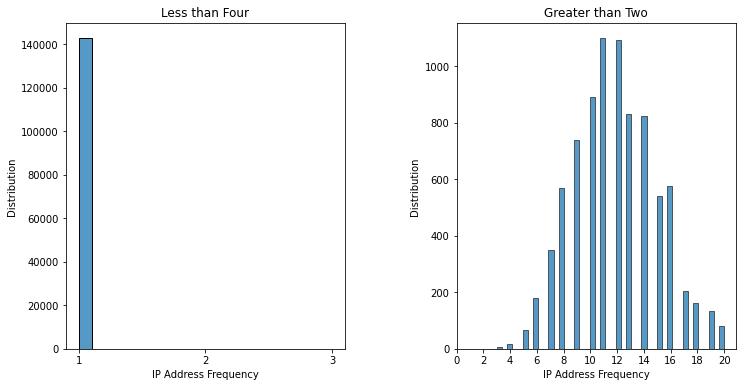

In [299]:
f, ax = plt.subplots(1,2,figsize=(12,6))
f.subplots_adjust(wspace=0.4)
g1 =sns.histplot(fraud_data.ip_address_freq[fraud_data.ip_address_freq <4], ax=ax[0])
g1.set(xticks=[1,2,3])
ax[0].set_title('Less than Four')
ax[0].set_xlabel('IP Address Frequency')
ax[0].set_ylabel('Distribution')

g2 =sns.histplot(fraud_data.ip_address_freq[fraud_data.ip_address_freq >2], ax=ax[1])
g2.set(xticks = range(0,21,2))
ax[1].set_title('Greater than Two')
ax[1].set_xlabel('IP Address Frequency')
ax[1].set_ylabel('Distribution')

In [300]:
# Sometimes the same device uses a different IP address

fraud_data.loc[fraud_data['device_freq'] != fraud_data['ip_address_freq']]

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,countries_from_device,country_risk,age_group,device_freq,ip_address_freq
3,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,0,Japan,2,High risk,40 - 49,2,1
4,192767,2015-01-08 12:17:12,2015-04-28 02:09:42,15,ZTORJKTDMYTJH,Ads,Safari,M,32,2.568640e+09,0,United States,2,High risk,< 40,2,1
5,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,SEO,Chrome,F,34,7.359961e+08,0,Japan,2,High risk,< 40,2,1
6,366068,2015-05-14 04:54:06,2015-07-11 03:24:56,69,JQYCFABXAMQVP,Direct,Chrome,M,31,3.463947e+09,0,United States,2,High risk,< 40,2,1
8,135536,2015-05-03 22:40:07,2015-07-18 15:43:38,32,ITRXCOXKEQTAM,SEO,FireFox,M,37,2.097968e+09,0,Japan,2,High risk,< 40,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147699,117273,2015-01-26 19:33:36,2015-03-27 23:30:39,22,KOJFCKWQDVVEH,SEO,IE,M,42,3.035673e+09,0,Singapore,2,High risk,40 - 49,2,1
148522,122957,2015-05-08 23:21:35,2015-05-26 01:28:24,59,ELZOBQQBWGXFB,SEO,IE,F,30,2.662716e+09,0,Kyrgyzstan,2,Low risk,< 40,2,1
148523,288005,2015-06-09 17:52:14,2015-07-06 07:20:29,9,ELZOBQQBWGXFB,Ads,FireFox,F,18,1.941611e+09,0,Pakistan,2,Medium risk,< 40,2,1
149663,180813,2015-05-10 20:17:06,2015-08-19 14:57:09,54,MRFQINZDKDSUW,Ads,Chrome,F,38,3.158383e+09,0,Oman,2,Low risk,< 40,2,1


### Add a same_purchase_freq column that groups how many times the same device purchased an item with the same value

In [301]:
#  Create a series that indicates, for each line, if the device_id and purchase_value combination has duplicates
duplicate = fraud_data.duplicated(subset = ['purchase_value','device_id'], keep = False)
# Merge the series with a dataframe containing purchase_value and device_id
duplicate = pd.concat([fraud_data.loc[:,['purchase_value','device_id']], duplicate],axis=1)
# Create a dataframe that shows the number of duplicates for each device_id and purchase_value combination
duplicate = duplicate.groupby(['device_id','purchase_value']).sum()
# Add a same_purchase_freq column that groups the duplicate count of each device_id and purchase_value combination
duplicate['same_purchase_freq'] = duplicate[0].apply(lambda x : 
                                                str(x) if x < 5 else
                                                '5-10' if x<=10 else
                                                '11-15' if x<= 15 else
                                                '>15' 
                                               )
                                            
# Merge the resulting duplicate dataframe with the main fraud_data dataset            
fraud_data = fraud_data.merge(duplicate.drop(0,axis=1), left_on=['device_id','purchase_value'], right_index = True)

In [302]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,countries_from_device,country_risk,age_group,device_freq,ip_address_freq,same_purchase_freq
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,High risk,< 40,1,1,0
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,0,Japan,1,High risk,< 40,1,1,0
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,0,Japan,1,High risk,40 - 49,1,1,0
3,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,0,Japan,2,High risk,40 - 49,2,1,0
4,192767,2015-01-08 12:17:12,2015-04-28 02:09:42,15,ZTORJKTDMYTJH,Ads,Safari,M,32,2.568640e+09,0,United States,2,High risk,< 40,2,1,0


In [303]:
# fraud_data.same_purchase_freq.value_counts()

### Add columns related to the date and time of day

In [304]:
fraud_data.signup_time = pd.to_datetime(fraud_data.signup_time, format = '%Y-%m-%d %H:%M:%S')
fraud_data.purchase_time = pd.to_datetime(fraud_data.purchase_time, format = '%Y-%m-%d %H:%M:%S')

# Add a 'month of purchase' column
fraud_data['purchase_month'] = fraud_data.purchase_time.apply(lambda x: calendar.month_name[x.month])

# Add a 'week of purchase' column
fraud_data['purchase_weekday'] = fraud_data.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])

# Add an 'hour of purchase' column
fraud_data['purchase_hour'] = fraud_data.purchase_time.apply(lambda x: x.hour)

# Add a 'seconds since signup'
fraud_data['seconds_since_signup']= (fraud_data.purchase_time - fraud_data.signup_time).apply(lambda x : x.total_seconds())

In [305]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,countries_from_device,country_risk,age_group,device_freq,ip_address_freq,same_purchase_freq,purchase_month,purchase_weekday,purchase_hour,seconds_since_signup
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,1,High risk,< 40,1,1,0,April,Saturday,2,4506682.0
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,...,1,High risk,< 40,1,1,0,April,Thursday,17,5959702.0
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,...,1,High risk,40 - 49,1,1,0,August,Monday,5,662649.0
3,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,...,2,High risk,40 - 49,2,1,0,January,Monday,12,82537.0
4,192767,2015-01-08 12:17:12,2015-04-28 02:09:42,15,ZTORJKTDMYTJH,Ads,Safari,M,32,2.568640e+09,...,2,High risk,< 40,2,1,0,April,Tuesday,2,9467550.0


In [306]:
# fraud_data.purchase_month.value_counts()

In [307]:
# fraud_data.purchase_weekday.value_counts()

In [308]:
# fraud_data.purchase_hour.value_counts()

In [309]:
# fraud_data.seconds_since_signup.value_counts()

In [310]:
fraud_data.describe()

,user_id,signup_time,purchase_time,purchase_value,age,ip_address,class,countries_from_device,device_freq,ip_address_freq,purchase_hour,seconds_since_signup
count,151112.000000,151112,151112,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,1.511120e+05
mean,200171.040970,2015-04-20 00:56:09.511329536,2015-06-16 02:56:38.759952640,36.935372,33.140704,2.152145e+09,0.093646,1.063489,1.684367,1.602719,11.521593,4.932029e+06
min,2.000000,2015-01-01 00:00:42,2015-01-01 00:00:44,9.000000,18.000000,5.209350e+04,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000e+00
25%,100642.500000,2015-02-18 09:52:48.500000,2015-04-18 14:41:25.500000,22.000000,27.000000,1.085934e+09,0.000000,1.000000,1.000000,1.000000,6.000000,2.186754e+06
50%,199958.000000,2015-04-19 04:41:30,2015-06-18 13:46:17.500000,35.000000,33.000000,2.154770e+09,0.000000,1.000000,1.000000,1.000000,12.000000,4.926346e+06
75%,300054.000000,2015-06-18 14:47:22.750000128,2015-08-17 18:48:31.500000,49.000000,39.000000,3.243258e+09,0.000000,1.000000,1.000000,1.000000,17.000000,7.644524e+06
max,400000.000000,2015-08-18 04:40:29,2015-12-16 02:56:05,154.000000,76.000000,4.294850e+09,1.000000,4.000000,20.000000,20.000000,23.000000,1.036797e+07
std,115369.285024,NaN,NaN,18.322762,8.617733,1.248497e+09,0.291336,0.248146,2.616954,2.596240,6.912474,3.126263e+06


In [311]:
# Group by the period of the day at which the purchase was made
fraud_data['purchase_period_of_day'] = fraud_data.purchase_hour.apply(lambda x : 
                                                             'late night' if x < 4 else
                                                             'early morning' if x < 8 else
                                                             'morning' if x < 12 else
                                                             'early afternoon' if x < 16 else
                                                             'afternoon' if x < 20 else
                                                             'evening'
                                                            )

In [312]:
fraud_data.seconds_since_signup.min()

1.0

In [313]:
fraud_data.seconds_since_signup.max()

10367972.0

In [314]:
pd.qcut(fraud_data.seconds_since_signup, q=19)

0         (4062544.421, 4642407.474]
1           (5781175.0, 6352782.263]
2            (608744.421, 1201455.0]
3            (26337.053, 608744.421]
4           (9218721.211, 9788699.0]
                     ...            
151107    (3489097.684, 4062544.421]
151108       (608744.421, 1201455.0]
151109      (5781175.0, 6352782.263]
151110       (608744.421, 1201455.0]
151111       (608744.421, 1201455.0]
Name: seconds_since_signup, Length: 151112, dtype: category
Categories (19, interval[float64, right]): [(0.999, 26337.053] < (26337.053, 608744.421] < (608744.421, 1201455.0] < (1201455.0, 1766604.789] ... (8079595.263, 8647682.737] < (8647682.737, 9218721.211] < (9218721.211, 9788699.0] < (9788699.0, 10367972.0]]

In [315]:
fraud_data['seconds_since_signup_cat'] = pd.qcut(fraud_data.seconds_since_signup, q=19)

In [316]:
fraud_data['seconds_since_signup_cat_str'] = fraud_data['seconds_since_signup_cat'].astype(str)

In [317]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,device_freq,ip_address_freq,same_purchase_freq,purchase_month,purchase_weekday,purchase_hour,seconds_since_signup,purchase_period_of_day,seconds_since_signup_cat,seconds_since_signup_cat_str
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,1,1,0,April,Saturday,2,4506682.0,late night,"(4062544.421, 4642407.474]","(4062544.421, 4642407.474]"
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,...,1,1,0,April,Thursday,17,5959702.0,afternoon,"(5781175.0, 6352782.263]","(5781175.0, 6352782.263]"
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,...,1,1,0,August,Monday,5,662649.0,early morning,"(608744.421, 1201455.0]","(608744.421, 1201455.0]"
3,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,...,2,1,0,January,Monday,12,82537.0,early afternoon,"(26337.053, 608744.421]","(26337.053, 608744.421]"
4,192767,2015-01-08 12:17:12,2015-04-28 02:09:42,15,ZTORJKTDMYTJH,Ads,Safari,M,32,2.568640e+09,...,2,1,0,April,Tuesday,2,9467550.0,late night,"(9218721.211, 9788699.0]","(9218721.211, 9788699.0]"


In [318]:
# fraud_data['seconds_since_signup_cat'].value_counts()

In [319]:
def sort_bins(bin_col):
    '''
    Sorts bins after using pd.cut. Increasing order. Puts 'NaN' bin at the beginning. 

    Input:
        bin_col: pd.series containing bins to be sorted

    '''

    # Dictionary to store first value from each bin
    vals = {}

    # Iterate through all bins
    for i, item in enumerate(bin_col.unique()):

        # Check if bin is 'nan', if yes, assign low value to put it at the beginning
        if item == 'nan':
            vals[i] = -99999

        # If not 'nan', get the first value from bin to sort later
        else:
            vals[i] = float(item.split(',')[0][1:])

    # Sort bins according to extracted first values
    ixs = list({k: v for k, v in \
                    sorted(vals.items(), key=lambda item: item[1])}.keys())

    # Make sorted list of bins
    sorted_bins = bin_col.unique()[list(ixs)]

    return sorted_bins

In [320]:
# Example, assuming 'age_bin' column has the bins:
sorted_bins = sort_bins(fraud_data['seconds_since_signup_cat_str'])

In [321]:
sorted_bins

array(['(0.999, 26337.053]', '(26337.053, 608744.421]',
       '(608744.421, 1201455.0]', '(1201455.0, 1766604.789]',
       '(1766604.789, 2329427.421]', '(2329427.421, 2906125.947]',
       '(2906125.947, 3489097.684]', '(3489097.684, 4062544.421]',
       '(4062544.421, 4642407.474]', '(4642407.474, 5208502.632]',
       '(5208502.632, 5781175.0]', '(5781175.0, 6352782.263]',
       '(6352782.263, 6933466.368]', '(6933466.368, 7498441.211]',
       '(7498441.211, 8079595.263]', '(8079595.263, 8647682.737]',
       '(8647682.737, 9218721.211]', '(9218721.211, 9788699.0]',
       '(9788699.0, 10367972.0]'], dtype=object)

In [322]:
fraud_data['quick_purchase'] = fraud_data.seconds_since_signup.apply(lambda x : 1 if x < 137 else 0)

In [323]:
# fraud_data.quick_purchase.value_counts()

In [324]:
fraud_data['first_purchase'] = fraud_data.apply(lambda x : 
                                         1 if x.purchase_time == fraud_data.purchase_time[fraud_data.device_id == x.device_id].min() else 0,
                                         axis =1)

In [325]:
# fraud_data.first_purchase.value_counts()

### Explore Likelihood of Fraud by Category

In [326]:
# fraud_data.groupby('source').head()
fraud_data.groupby('source')['class'].mean()
fraud_data.groupby('source')['class'].mean().index
# .mean()

Index(['Ads', 'Direct', 'SEO'], dtype='object', name='source')

In [327]:
# fraud_data['country'].value_counts()


In [328]:
fraud_data.groupby('country')['class'].mean().sort_values(ascending=False)[:28]

country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Ireland                  0.229167
New Zealand              0.223022
Uzbekistan               0.200000
Lithuania                0.189474
Saudi Arabia             0.189394
Malta                    0.181818
Afghanistan              0.166667
Cote D'ivoire            0.166667
Denmark                  0.159184
Chile                    0.153477
Greece                   0.142857
Malawi                   0.142857
Montenegro               0.142857
United Arab Emirates     0.140351
Belgium                  0.136919
Egypt                    0.133705
Armenia                  0.133333
Costa Rica               0.133333
Name: class, dtype: float64

In [329]:
#Filter countries to those with at least 1000 transactions

relevant_countries = fraud_data['country'].value_counts() > 1000
relevant_countries_list = list(relevant_countries[relevant_countries == True].index)
relevant_countries_list



['United States',
 'Unknown',
 'China',
 'Japan',
 'United Kingdom',
 'Korea Republic of',
 'Germany',
 'France',
 'Canada',
 'Brazil',
 'Italy',
 'Australia',
 'Netherlands',
 'Russian Federation',
 'India',
 'Taiwan; Republic of China (ROC)',
 'Mexico',
 'Sweden',
 'Spain']

In [330]:
fraud_data[fraud_data['country'].isin(relevant_countries_list)].groupby('country')['class'].mean().sort_values(ascending=False)[:28]

country
Mexico                             0.128457
Sweden                             0.120183
Canada                             0.116975
India                              0.115267
United Kingdom                     0.106236
Japan                              0.097865
United States                      0.095626
France                             0.094907
Korea Republic of                  0.091302
Brazil                             0.091185
Australia                          0.089479
China                              0.086642
Unknown                            0.085723
Italy                              0.085391
Russian Federation                 0.082921
Taiwan; Republic of China (ROC)    0.080032
Netherlands                        0.073214
Germany                            0.071860
Spain                              0.071081
Name: class, dtype: float64

/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

[Text(0, 0, 'Mexico'),
 Text(1, 0, 'Sweden'),
 Text(2, 0, 'Canada'),
 Text(3, 0, 'India'),
 Text(4, 0, 'United Kingdom'),
 Text(5, 0, 'Japan'),
 Text(6, 0, 'United States'),
 Text(7, 0, 'France'),
 Text(8, 0, 'Korea Republic of'),
 Text(9, 0, 'Brazil'),
 Text(10, 0, 'Australia'),
 Text(11, 0, 'China'),
 Text(12, 0, 'Unknown'),
 Text(13, 0, 'Italy'),
 Text(14, 0, 'Russian Federation'),
 Text(15, 0, 'Taiwan; Republic of China (ROC)'),
 Text(16, 0, 'Netherlands'),
 Text(17, 0, 'Germany'),
 Text(18, 0, 'Spain')]

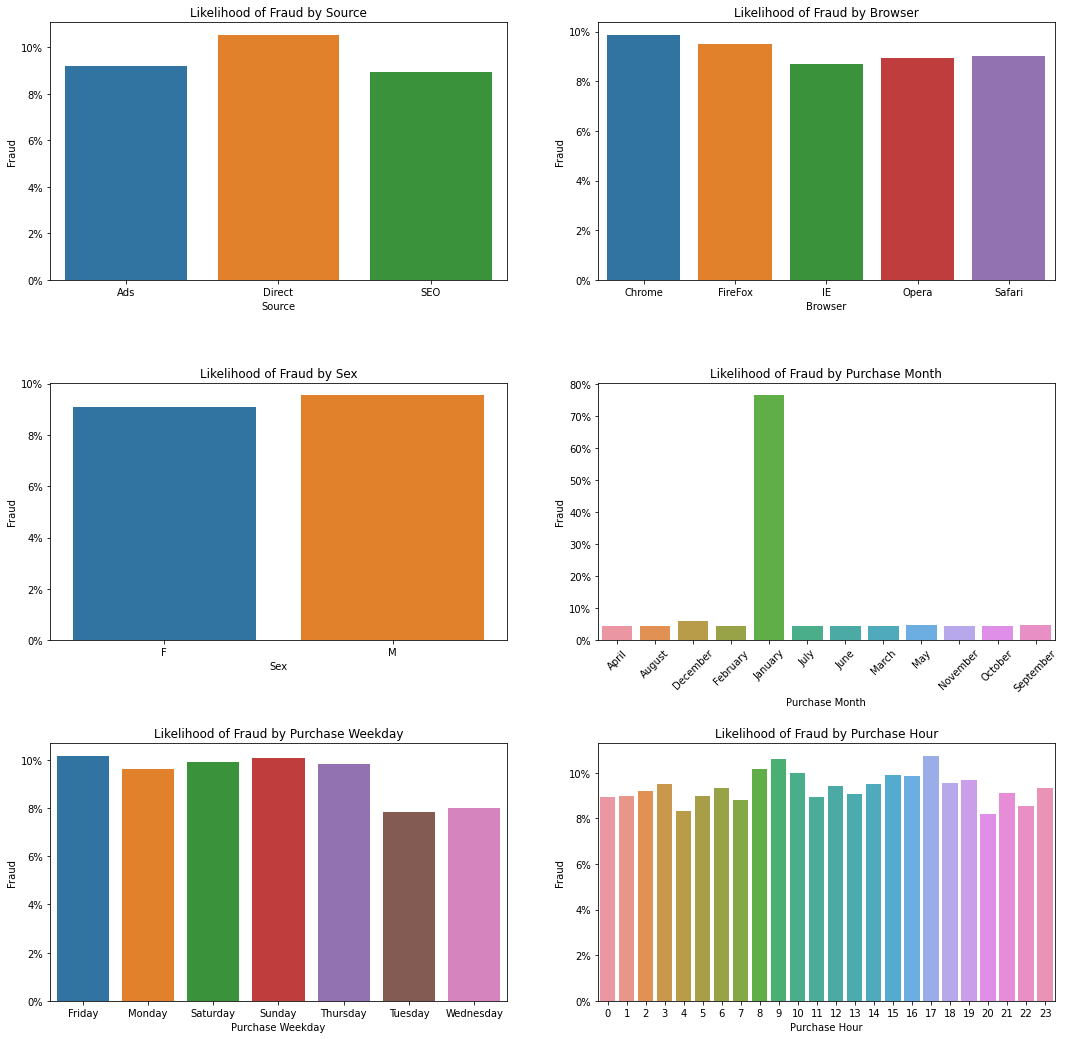

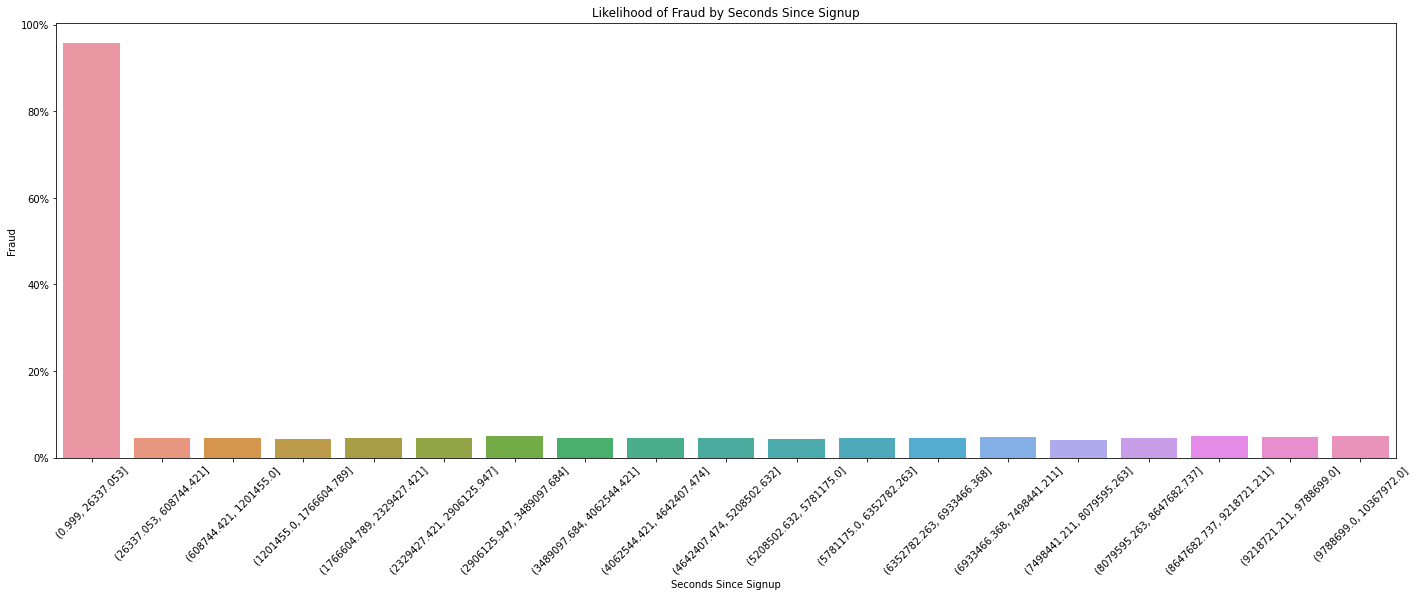

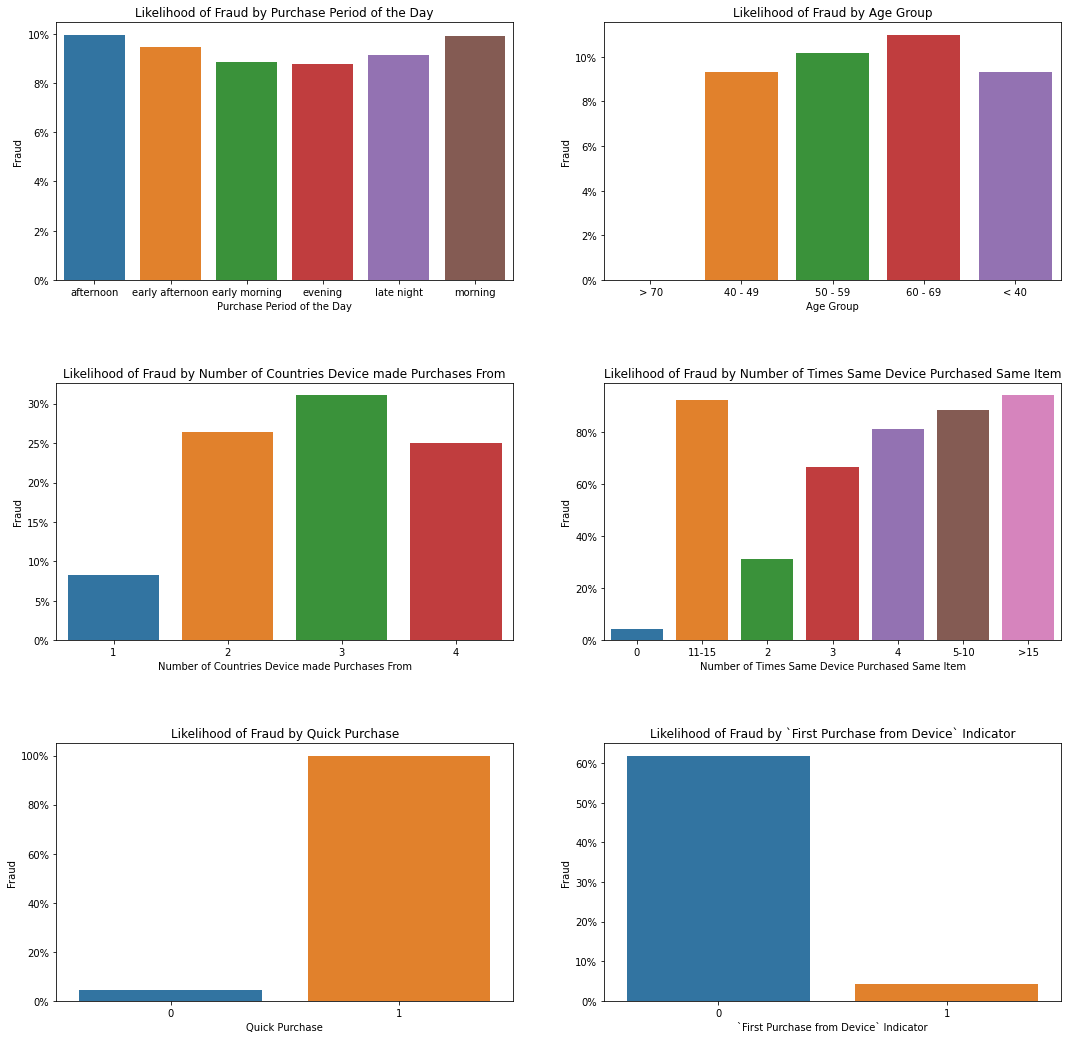

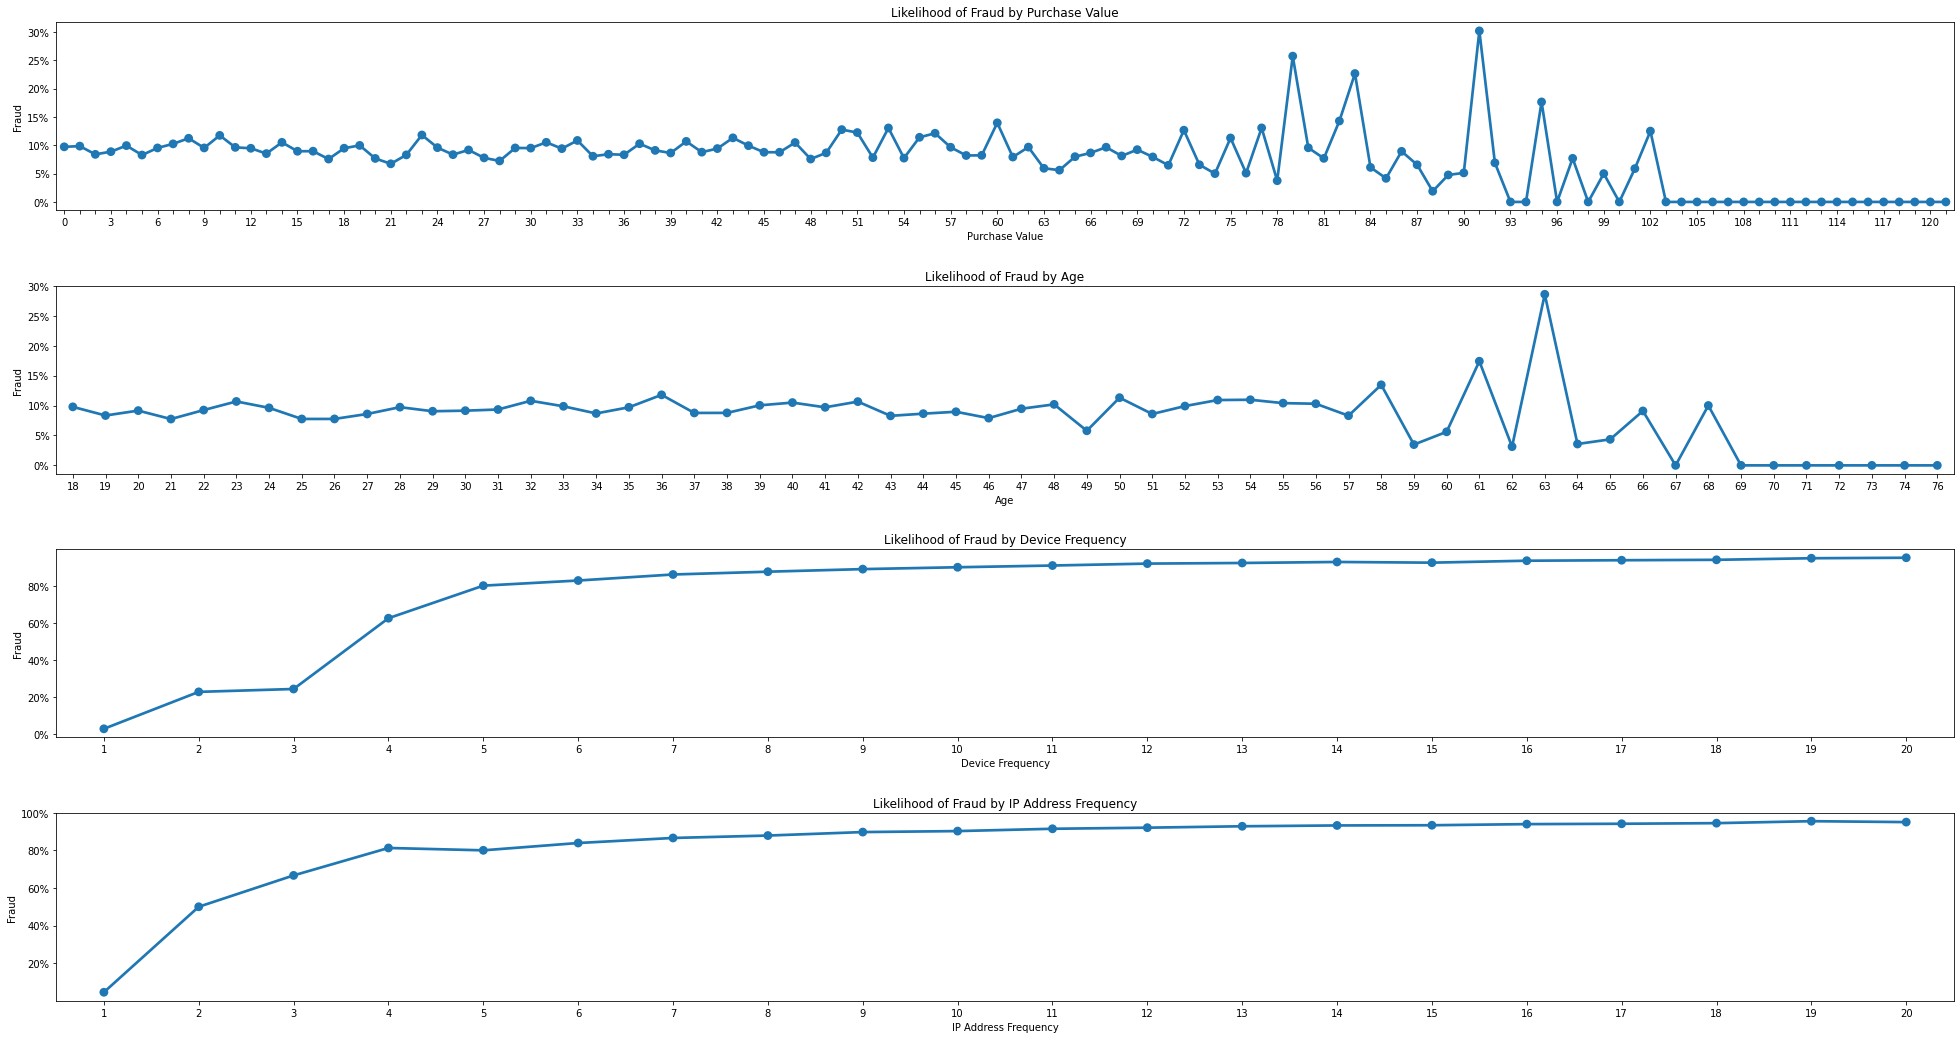

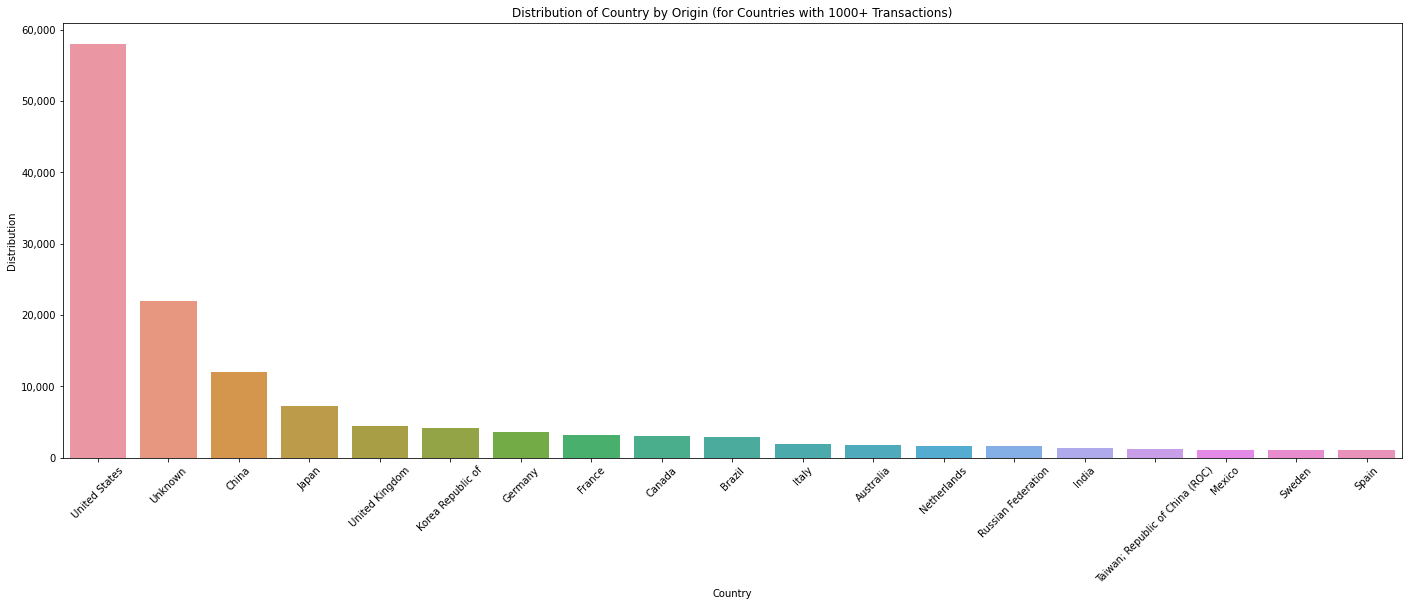

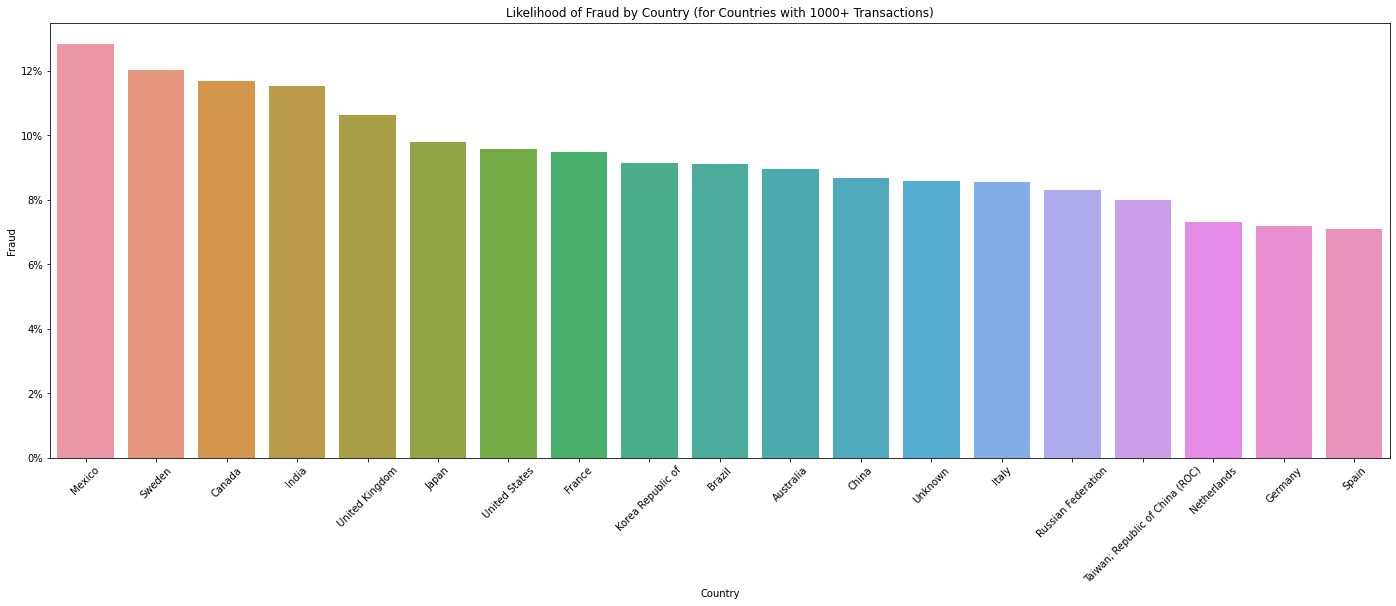

In [331]:
# We look at the likelihood of fraud per category

f, ax = plt.subplots(3, 2, figsize =(18, 18))
f.subplots_adjust(hspace=0.4)

f2, ax2 = plt.subplots(1, 1, figsize =(24, 8))

f3, ax3 = plt.subplots(3, 2, figsize =(18, 18))
f3.subplots_adjust(hspace=0.4)

f4, ax4 = plt.subplots(4, 1, figsize =(34, 18))
f4.subplots_adjust(hspace=0.4)

f5, ax5 = plt.subplots(1, 1, figsize =(24, 8))

f6, ax6 = plt.subplots(1, 1, figsize =(24, 8))

# Direct sources have the highest likelihood of fraud at 10.5%, followed by ads at 9.2%, then SEO at 8.9%
sns.barplot(fraud_data.groupby('source')['class'].mean().index, fraud_data.groupby('source')['class'].mean(), ax = ax[0, 0])
ax[0, 0].set_title('Likelihood of Fraud by Source')
ax[0, 0].set_xlabel('Source')
ax[0, 0].set_ylabel('Fraud')
ax[0, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Chrome browsers have the highest likelihood of fraud at 9.9%, followed by FireFox (9.5%), Safari (9.0%), Opera (8.9%) and IE (8.7%)
sns.barplot(fraud_data.groupby('browser')['class'].mean().index, fraud_data.groupby('browser')['class'].mean(), ax = ax[0, 1])
ax[0, 1].set_title('Likelihood of Fraud by Browser')
ax[0, 1].set_xlabel('Browser')
ax[0, 1].set_ylabel('Fraud')
ax[0, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Males have a higher likelihood of fraud at 9.65% compared to females (9.1%)
sns.barplot(fraud_data.groupby('sex')['class'].mean().index, fraud_data.groupby('sex')['class'].mean(), ax = ax[1, 0])
ax[1, 0].set_title('Likelihood of Fraud by Sex')
ax[1, 0].set_xlabel('Sex')
ax[1, 0].set_ylabel('Fraud')
ax[1, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# January has, by far, the highest likelihood of fraud at 76.5%. December comes in second, with a much lower 6.0% fraud occurrence. 
# This may be related to holiday shopping and returns, following Christmas and Black Friday (Day after Thanksgiving).
sns.barplot(fraud_data.groupby('purchase_month')['class'].mean().index, fraud_data.groupby('purchase_month')['class'].mean(), ax = ax[1, 1])
ax[1, 1].set_title('Likelihood of Fraud by Purchase Month')
ax[1, 1].set_xlabel('Purchase Month')
ax[1, 1].set_ylabel('Fraud')
ax[1, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax[1, 1].set_xticklabels(fraud_data.groupby('purchase_month')['class'].mean().index, rotation = 45)

# Weekends have the highest occurence of Fraud, with Fridays at 10.2%, Sundays at 10.1% and Saturdays at 9.9%. Next comes Thursday (9.8%), Monday (9.6%),
# Wednesday (8.0%) and Tuesday (7.8%)
sns.barplot(fraud_data.groupby('purchase_weekday')['class'].mean().index, fraud_data.groupby('purchase_weekday')['class'].mean(), ax = ax[2, 0])
ax[2, 0].set_title('Likelihood of Fraud by Purchase Weekday')
ax[2, 0].set_xlabel('Purchase Weekday')
ax[2, 0].set_ylabel('Fraud')
ax[2, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# The peaks for fraud likelihood are in the evening, at 10.7% around 8pm, and then the morning, at 10.6% around 9am.
sns.barplot(fraud_data.groupby('purchase_hour')['class'].mean().index, fraud_data.groupby('purchase_hour')['class'].mean(), ax = ax[2, 1])
ax[2, 1].set_title('Likelihood of Fraud by Purchase Hour')
ax[2, 1].set_xlabel('Purchase Hour')
ax[2, 1].set_ylabel('Fraud')
ax[2, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is most likely when a purchase is made in the first 7 hours and 19 minutes (26,337 seconds) after signup, with an occurence of 95.7%, compared with a 
# range of 4.1% to 5.0% for times periods after the first 7 hours and 19 minutes. Thus, quicker purchases are more likely to be fraudulent.
sns.barplot(fraud_data.groupby('seconds_since_signup_cat')['class'].mean().index, fraud_data.groupby('seconds_since_signup_cat')['class'].mean(), ax = ax2)
ax2.set_title('Likelihood of Fraud by Seconds Since Signup')
ax2.set_xlabel('Seconds Since Signup')
ax2.set_ylabel('Fraud')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax2.set_xticklabels(fraud_data.groupby('seconds_since_signup_cat')['class'].mean().index, rotation = 45) 

# Mornings and afternoons have the highest likelihood of fraud with afternoons at 10.0%, mornings at 9.9% and early afternoons
# at 9.5%
sns.barplot(fraud_data.groupby('purchase_period_of_day')['class'].mean().index, fraud_data.groupby('purchase_period_of_day')['class'].mean(), ax = ax3[0, 0])
ax3[0, 0].set_title('Likelihood of Fraud by Purchase Period of the Day')
ax3[0, 0].set_xlabel('Purchase Period of the Day')
ax3[0, 0].set_ylabel('Fraud')
ax3[0, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is highest for those between the ages of 60 and 69 (at 11.0%) followed by those between the ages of 50 and 59 (at 10.2%).
sns.barplot(fraud_data.groupby('age_group')['class'].mean().index, fraud_data.groupby('age_group')['class'].mean(), ax = ax3[0, 1])
ax3[0, 1].set_title('Likelihood of Fraud by Age Group')
ax3[0, 1].set_xlabel('Age Group')
ax3[0, 1].set_ylabel('Fraud')
ax3[0, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is highest (31.1%) when purchases from the same device are made from three countries, followed by two countries (26.4%)
# and then four countries (25.0%)
sns.barplot(fraud_data.groupby('countries_from_device')['class'].mean().index, fraud_data.groupby('countries_from_device')['class'].mean(), ax = ax3[1, 0])
ax3[1, 0].set_title('Likelihood of Fraud by Number of Countries Device made Purchases From')
ax3[1, 0].set_xlabel('Number of Countries Device made Purchases From')
ax3[1, 0].set_ylabel('Fraud')
ax3[1, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is higher the more the same device makes purchases for the same item, with 15 or more purchases at 94.3%, 11 to 15
# purchases at 92.4%, 5 to 10 at 88.5% and progressively lower from 4 (81.3%) to none (4.5%).
sns.barplot(fraud_data.groupby('same_purchase_freq')['class'].mean().index, fraud_data.groupby('same_purchase_freq')['class'].mean(), ax = ax3[1, 1])
ax3[1, 1].set_title('Likelihood of Fraud by Number of Times Same Device Purchased Same Item')
ax3[1, 1].set_xlabel('Number of Times Same Device Purchased Same Item')
ax3[1, 1].set_ylabel('Fraud')
ax3[1, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Within our data, fraud is guaranteed when purchases are made less than 137 seconds after signing up. Whereas fraud occurs in only
# 4.6% of purchase transactions made 137 seconds or more after signing up.
sns.barplot(fraud_data.groupby('quick_purchase')['class'].mean().index, fraud_data.groupby('quick_purchase')['class'].mean(), ax = ax3[2, 0])
ax3[2, 0].set_title('Likelihood of Fraud by Quick Purchase')
ax3[2, 0].set_xlabel('Quick Purchase')
ax3[2, 0].set_ylabel('Fraud')
ax3[2, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is more likely to occur after one purchase has been made from that device. For the first purchase from the device, fraud
# occurred only 4.4% compared to 61.9% in subsequent purchases from that device.
sns.barplot(fraud_data.groupby('first_purchase')['class'].mean().index, fraud_data.groupby('first_purchase')['class'].mean(), ax = ax3[2, 1])
ax3[2, 1].set_title('Likelihood of Fraud by `First Purchase from Device` Indicator')
ax3[2, 1].set_xlabel('`First Purchase from Device` Indicator')
ax3[2, 1].set_ylabel('Fraud')
ax3[2, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is more likely for purchase values between an $80 and $104 range, where the likelihood ranges between 12.7% and 30.2%.
sns.pointplot(data = fraud_data, x = 'purchase_value', y = 'class', ci = None, ax = ax4[0])
ax4[0].set_title('Likelihood of Fraud by Purchase Value')
ax4[0].set_xlabel('Purchase Value')
ax4[0].set_ylabel('Fraud')
ax4[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

original_labels = [label for label in ax4[0].get_xticks()]
min_lab = min(original_labels)
max_lab = max(original_labels)
labels_of_interest = [i for i in np.arange(min_lab, max_lab, 3)]
new_labels = [label if label in labels_of_interest else '' for label in original_labels]
ax4[0].set_xticklabels(new_labels)

# Fraud peaks around the early 60s, with the highest likelihood at 63 with 28.6%, followed by 61 at 17.4% and 58 with 13.4%.
sns.pointplot(data = fraud_data, x = 'age', y = 'class', ci = None, ax = ax4[1])
ax4[1].set_title('Likelihood of Fraud by Age')
ax4[1].set_xlabel('Age')
ax4[1].set_ylabel('Fraud')
ax4[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is most likely to occur when purchases are made from the same device. Device frequencies of 20 have the highest likelihood of fraud, at 95%, followed by 
# device frequencies of 19, 18, and 17, and then progressively dropping until we reach the lowest likelihood of fraud, with purchases from only one device, at 
# only 3.0% likelihood.
sns.pointplot(data = fraud_data, x = 'device_freq', y = 'class', ci = None, ax = ax4[2])
ax4[2].set_title('Likelihood of Fraud by Device Frequency')
ax4[2].set_xlabel('Device Frequency')
ax4[2].set_ylabel('Fraud')
ax4[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Fraud is most likely to occur when purchases are made from the same IP address. IP address frequencies of 19 have the highest likelihood of fraud, at 95.5%, 
# followed by IP address frequencies of 20 at 95%, and 18 at 94.4%, and then progressively dropping mostly sequentially until we reach the lowest likelihood of 
# fraud, with purchases from only one IP address at 4.6% likelihood.
sns.pointplot(data = fraud_data, x = 'ip_address_freq', y = 'class', ci = None, ax = ax4[3])
ax4[3].set_title('Likelihood of Fraud by IP Address Frequency')
ax4[3].set_xlabel('IP Address Frequency')
ax4[3].set_ylabel('Fraud')
ax4[3].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Evaluating countries, we see that fraud is most likely to occur in Turkmenistan (100%), Namibia (43.5%), Sri Lanka (41.9%), Luxembourg (38.9%) and the 
# U.S. Virgin Islands (33.3%). However, the number of transactions for these countries are sparse within our dataset.
# When we limit the analysis to countries with at least 1,000 transactions within our dataset, we see that fraud is most likely to occur in Mexico (12.0%), 
# followed by Sweden (12.0%), then Canada (11.7%), India (11.5%), United Kingdom (10.6%), Japan (9.8%) and then the United States (9.6%). 
# I am keeping unknown countries in the dataset because they may be an indication of a fraudulent activity since fraudsters go to great lengths to avoid being traced.
sns.barplot(fraud_data.country.value_counts()[fraud_data.country.value_counts() > 1000].index, fraud_data.country.value_counts()[fraud_data.country.value_counts() > 1000], ax = ax5)
ax5.set_title('Distribution of Country by Origin (for Countries with 1000+ Transactions)')
ax5.set_xlabel('Country')
ax5.set_ylabel('Distribution')
ax5.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 
ax5.set_xticklabels(fraud_data.country.value_counts()[fraud_data.country.value_counts() > 1000].index, rotation = 45)  

sns.barplot(fraud_data[fraud_data['country'].isin(relevant_countries_list)].groupby('country')['class'].mean().sort_values(ascending=False).index[:28], fraud_data[fraud_data['country'].isin(relevant_countries_list)].groupby('country')['class'].mean().sort_values(ascending=False)[:28], ax = ax6)
ax6.set_title('Likelihood of Fraud by Country (for Countries with 1000+ Transactions)')
ax6.set_xlabel('Country')
ax6.set_ylabel('Fraud')
ax6.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax6.set_xticklabels(fraud_data[fraud_data['country'].isin(relevant_countries_list)].groupby('country')['class'].mean().sort_values(ascending=False).index[:28], rotation = 45)  

After reviewing visuals, it is apparent that our highest predictors of fraud are:
- Quick Purchases: Specifically, purchases made 136 seconds or less after sign up are guaranteed to be fraudulent.
- January Purchases: Purchases made in the month of January are 76.5% likely to be fraudulent.
- Same Purchase Frequency of Three or More: Purchases made three or more times from the same device for the same item, with 15 or more purchases at 94.3%, 11 to 15 purchases at 92.4%, 5 to 10 at 88.5%, 4 at 81.3% and 3 at 66.7%.
- Subsequent Purchases: For subsequent purchases from the same device, fraud occurred 61.9% of the time compared to 4.4% for first purchases.

We have specific indicators for most high-risk categories, except January. A January variable will ease analysis. 

In [332]:
fraud_data['january_purchase'] = fraud_data.purchase_weekday.apply(lambda x : 1 if x == 'January' else 0)

In [333]:
# fraud_data.info()

In [334]:
fraud_data.to_csv('data/Fraud_Data_after_Feature_Eng.csv')

### Drop columns not needed for modeling

In [335]:
fraud_data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'age', 'ip_address', 'country', 'purchase_hour',
                 'seconds_since_signup', 'seconds_since_signup_cat', 'seconds_since_signup_cat_str'], axis = 1, inplace = True)

In [336]:
# fraud_data.info()

## Modeling

For our models, we want to minimize both false negatives (i.e. fraud not detected) and false positives (i.e. blocked transactions which were actually not fraudulent) so the evaluation metric that is most relevant would be accuracy. However, a disadvantage of using accuracy as a metric is that it can be misleadingly high when there is a significant class imbalance. Earlier, we found that the proportion of fraud in this dataset (as measured by the 'class' column) is 9.36%. Because there are fewer observations in the fraud class (i.e. the minority class), it may be harder for a model to effectively learn the decision boundary. This can be solved by oversampling observations in the minority class by synthesizing new observation from the minority class using SMOTE (Synthetic Minority Oversampling Technique). 


### Define predictor (X) and target (y) variables

In [337]:
X = fraud_data.drop('class', axis=1)
y = fraud_data['class']

### Split the data between train and test sets

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.3)

### Perform one-hot encoding for categorical columns

In [339]:
# Specify the categorical columns to encode
X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

# Create an instance of the OneHotEncoder
ohe = OneHotEncoder(drop = 'first', sparse = False)

# Transform the categorical columns in both the training and testing sets
X_train_dummies = pd.DataFrame(ohe.fit_transform(X_train_cat), columns=ohe.get_feature_names_out(), index=X_train_cat.index)
X_test_dummies = pd.DataFrame(ohe.fit_transform(X_test_cat), columns=ohe.get_feature_names_out(), index=X_test_cat.index)

/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Normalize numerical columns by scaling the train and test sets

In [340]:
# Specify the numerical columns to scale
X_train_nums = X_train.select_dtypes('int64')
X_test_nums = X_test.select_dtypes('int64')

# Create an instance of the StandardScaler
ss = StandardScaler()

# Transform the numerical columns in both the training and testing sets
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_nums), index = X_train_nums.index)
X_test_scaled = pd.DataFrame(ss.fit_transform(X_test_nums), index = X_test_nums.index)

X_train_scaled.columns = X_train_nums.columns
X_test_scaled.columns = X_test_nums.columns


### Merge the pre-processed categorical and numerical columns

In [341]:
X_train_clean = pd.concat([X_train_scaled, X_train_dummies], axis = 1)
X_test_clean = pd.concat([X_test_scaled, X_test_dummies], axis = 1)

X_train_clean.columns = X_train_clean.columns.astype(str)
X_test_clean.columns = X_test_clean.columns.astype(str)

In [342]:
y_train

62201     0
141967    0
85320     0
116317    0
62954     0
         ..
80696     0
138033    0
15011     0
24704     0
120714    0
Name: class, Length: 105778, dtype: int64

### Perform SMOTE to address the class imbalance of the fraud variable

In [343]:
# Create an instance of SMOTE
smote = SMOTE(random_state = 42)

# Apply SMOTE on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clean, y_train)

### MODEL 1: Apply a Dummy Classifier as the Baseline Model

In [344]:
# Create a baseline model
dummy_model = DummyClassifier(strategy = 'most_frequent')

# Train the model on the resampled training data
dummy_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_dummy = dummy_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print(classification_report(y_test, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41089
           1       0.00      0.00      0.00      4245

    accuracy                           0.91     45334
   macro avg       0.45      0.50      0.48     45334
weighted avg       0.82      0.91      0.86     45334



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

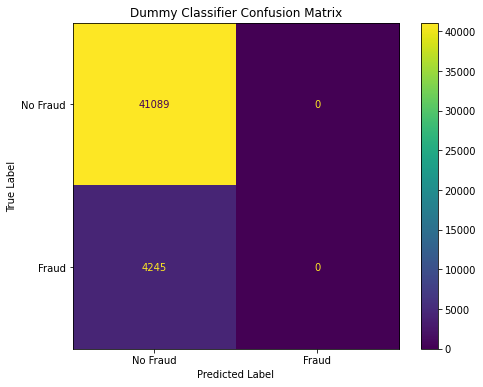

In [345]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_dummy)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title("Dummy Classifier Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot

plt.show()

### MODEL 2: Apply a Decision Tree Model

In [346]:
# Create an instance of the DecisionTreeClassifier
dt_model = DecisionTreeClassifier(max_depth = 3)

# Train the model on the resampled training data
dt_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_dt = dt_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     41089
           1       0.52      0.72      0.61      4245

    accuracy                           0.91     45334
   macro avg       0.75      0.83      0.78     45334
weighted avg       0.93      0.91      0.92     45334



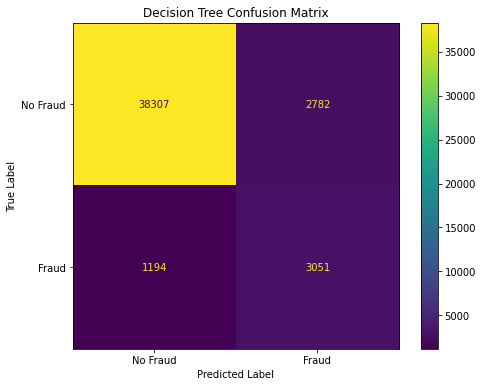

In [347]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot

plt.show()

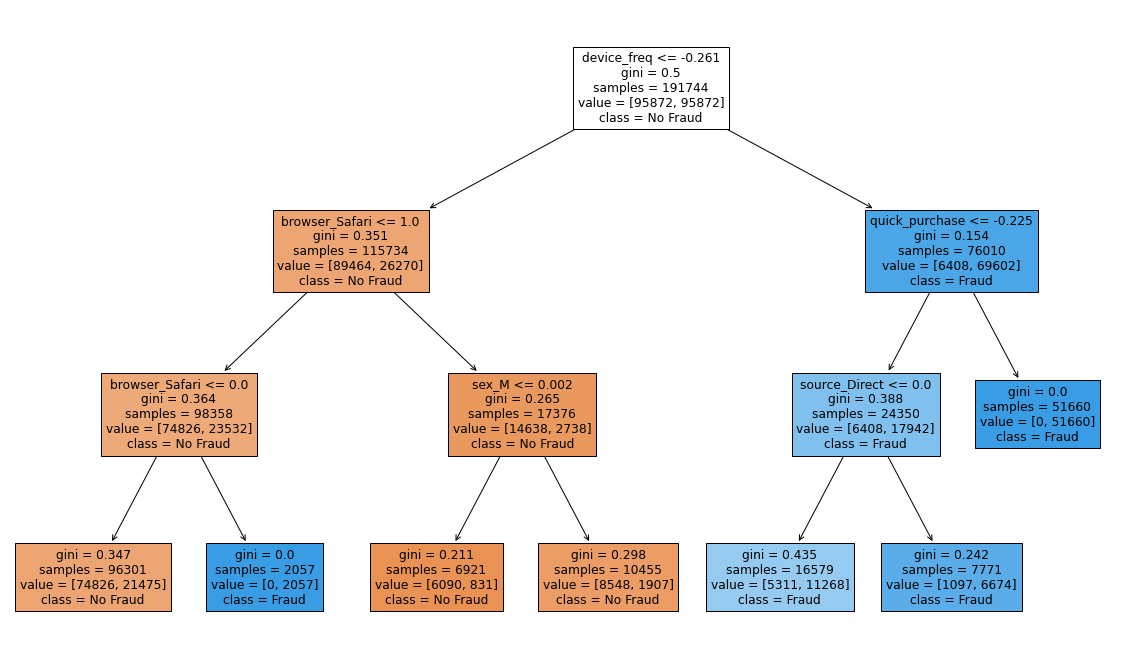

In [348]:
# Plot the decision tree
plt.figure(figsize=(20, 12))
tree.plot_tree(dt_model, feature_names = X_train_clean.columns, class_names=['No Fraud', 'Fraud'], filled = True)
plt.show()

In [349]:
feature_imp = {}
for fi, feature in zip(dt_model.feature_importances_, dt_model.feature_names_in_):
    feature_imp[feature] = fi

feature_imp

{'purchase_value': 0.0,
 'countries_from_device': 0.0,
 'device_freq': 0.8915680347822961,
 'ip_address_freq': 0.0,
 'quick_purchase': 0.04695722372228028,
 'first_purchase': 0.0,
 'january_purchase': 0.0,
 'source_Direct': 0.006959593609298011,
 'source_SEO': 0.0,
 'browser_FireFox': 0.0,
 'browser_IE': 0.0,
 'browser_Opera': 0.0,
 'browser_Safari': 0.053852275851237426,
 'sex_M': 0.0006628720348881947,
 'country_risk_Low risk': 0.0,
 'country_risk_Medium risk': 0.0,
 'country_risk_Very High risk': 0.0,
 'age_group_40 - 49': 0.0,
 'age_group_50 - 59': 0.0,
 'age_group_60 - 69': 0.0,
 'age_group_< 40': 0.0,
 'same_purchase_freq_11-15': 0.0,
 'same_purchase_freq_2': 0.0,
 'same_purchase_freq_3': 0.0,
 'same_purchase_freq_4': 0.0,
 'same_purchase_freq_5-10': 0.0,
 'same_purchase_freq_>15': 0.0,
 'purchase_month_August': 0.0,
 'purchase_month_December': 0.0,
 'purchase_month_February': 0.0,
 'purchase_month_January': 0.0,
 'purchase_month_July': 0.0,
 'purchase_month_June': 0.0,
 'purchas

### MODEL 3: Apply a Logistic Regression Model

In [350]:
# Create an instance of the logistic regression model
logreg_model = LogisticRegression()

# Train the model on the resampled training data
logreg_model.fit(X_train_resampled, y_train_resampled)

# Predict on the testing data
y_pred_logreg = logreg_model.predict(X_test_clean)

# Evaluate the model's performance using classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     41089
           1       0.54      0.72      0.62      4245

    accuracy                           0.92     45334
   macro avg       0.76      0.83      0.79     45334
weighted avg       0.93      0.92      0.92     45334



/Users/llakes/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [351]:
# Get the coefficients and intercept from the logistic regression model
coefficients = logreg_model.coef_
intercept = logreg_model.intercept_

# Create a DataFrame to display the coefficients
X_train_coefficients = pd.DataFrame(coefficients, columns=X_train_clean.columns)
X_train_coefficients['Intercept'] = intercept

# Print the coefficients
print("Coefficients:")
print(X_train_coefficients)

Coefficients:
   purchase_value  countries_from_device  device_freq  ip_address_freq  \
0       -0.023458                0.12551      4.24691        -4.245072   

   quick_purchase  first_purchase  january_purchase  source_Direct  \
0        4.621133       -0.046962               0.0       0.047274   

   source_SEO  browser_FireFox  ...  purchase_weekday_Sunday  \
0   -0.069247        -0.181128  ...                -0.159183   

   purchase_weekday_Thursday  purchase_weekday_Tuesday  \
0                  -0.171171                 -0.187709   

   purchase_weekday_Wednesday  purchase_period_of_day_early afternoon  \
0                   -0.131669                               -0.161737   

   purchase_period_of_day_early morning  purchase_period_of_day_evening  \
0                             -0.093739                       -0.155146   

   purchase_period_of_day_late night  purchase_period_of_day_morning  \
0                          -0.190773                       -0.135046   

   Inte

In [352]:
odds = np.exp(coefficients)

# Create a DataFrame to display the odds
X_train_odds = pd.DataFrame(odds, columns=X_train_clean.columns)

# Print the odds
print("Odds:")
print(X_train_odds)

Odds:
   purchase_value  countries_from_device  device_freq  ip_address_freq  \
0        0.976815               1.133726    69.889103         0.014335   

   quick_purchase  first_purchase  january_purchase  source_Direct  \
0      101.609061        0.954123               1.0       1.048409   

   source_SEO  browser_FireFox  ...  purchase_weekday_Saturday  \
0    0.933096         0.834328  ...                   0.893298   

   purchase_weekday_Sunday  purchase_weekday_Thursday  \
0                 0.852841                   0.842677   

   purchase_weekday_Tuesday  purchase_weekday_Wednesday  \
0                  0.828856                    0.876631   

   purchase_period_of_day_early afternoon  \
0                                0.850665   

   purchase_period_of_day_early morning  purchase_period_of_day_evening  \
0                              0.910521                         0.85629   

   purchase_period_of_day_late night  purchase_period_of_day_morning  
0                       

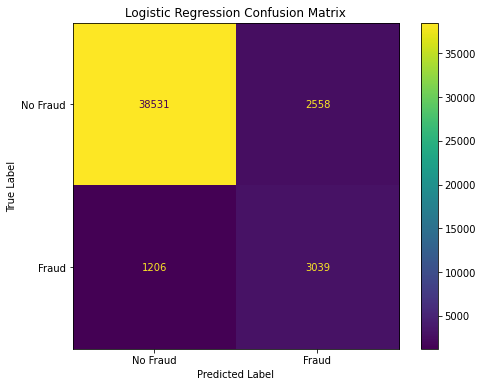

In [353]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Fraud', 'Fraud'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Add a title and axis labels
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot

plt.show()

In [354]:
logreg_scores = logreg_model.predict_proba(X_test_clean)

Use a Receiver Operating Characteristic (ROC) curve to plot the True Positive Rate vs. he False Positive Rate. 

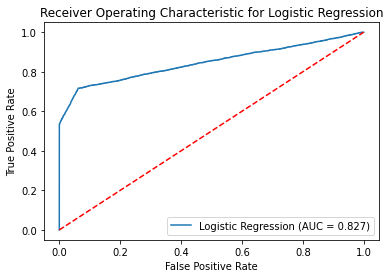

In [355]:
logreg_roc_auc = roc_auc_score(y_test, y_pred_logreg)
fpr, tpr, thresholds = roc_curve(y_test, logreg_scores[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.3f)' % logreg_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('logreg_roc')
plt.show()

Since we want our y-values (True Positive Rates) to be as high as possible for any particular x-value, a larger Area Under the Curve (AUC) indicates a better classifier. In this case, the AUC is 82.7%.

We want to set the appropriate level of threshold to reduce the number of false negatives (i.e. fraud not detected) without unduly increasing the cost of false positives (i.e. blocked transactions which were actually not fraudulent). We can examine the true- and false-positive rates for various thresholds:

In [356]:
def classify_rates(y_test, y_probs, thresh):
    y_hat = []
    for val in y_probs:                 # Each element in y_hat_probs is an array.
        if val[1] < thresh:             # We'll set our own threshold for classifying
            y_hat.append(0)             # a test point as positive! The lower my threshold,
        else:                           # the fewer predicted positives I'll have. For the
            y_hat.append(1)             # cancer example, I'd want to set a *high* threshold.
    cm = confusion_matrix(y_test, y_hat)
    tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr, f'tpr:{round(tpr, 3)}, fpr:{round(fpr, 3)}'

In [357]:
for x in np.linspace(0, 1, 11):
    print(f'Rates at threshold = {round(x, 2)}: '\
          + classify_rates(y_test, logreg_scores, x)[2])

Rates at threshold = 0.0: tpr:1.0, fpr:1.0
Rates at threshold = 0.1: tpr:1.0, fpr:0.996
Rates at threshold = 0.2: tpr:0.953, fpr:0.85
Rates at threshold = 0.3: tpr:0.734, fpr:0.114
Rates at threshold = 0.4: tpr:0.717, fpr:0.062
Rates at threshold = 0.5: tpr:0.716, fpr:0.062
Rates at threshold = 0.6: tpr:0.706, fpr:0.059
Rates at threshold = 0.7: tpr:0.659, fpr:0.042
Rates at threshold = 0.8: tpr:0.549, fpr:0.004
Rates at threshold = 0.9: tpr:0.539, fpr:0.002
Rates at threshold = 1.0: tpr:0.0, fpr:0.0


One way of choosing a threshold is to select the point on the curve that is furthest from (1, 0), the "worse-case" point where the True Positive Rate is 0 and the False Positive Rate is 1. So let's find that point as well:

In [358]:
tprs = []
fprs = []
diffs = []
for x in np.linspace(0, 1, 101):
    fprs.append(classify_rates(y_test, logreg_scores, x)[1])
    tprs.append(classify_rates(y_test, logreg_scores, x)[0])
    diffs.append(np.sqrt(tprs[-1]**2 + (1-fprs[-1])**2))
    
max_dist = diffs.index(np.max(diffs))
print(f"""The optimal threshold for the Logistic Regression Model is {(max_dist - 1) / 100} when: \n"""
      f"""\tThe True Positive Rate is {round(tprs[max_dist], 3)} \n"""
      f"""\tand the False Positive Rate is {round(fprs[max_dist], 3)}""")

The optimal threshold for the Logistic Regression Model is 0.4 when: 
	The True Positive Rate is 0.717 
	and the False Positive Rate is 0.062


In [359]:
# Changing the threshold from the 0.5 default to 0.4:
y_pred_new_threshold = (logreg_scores[:, 1] >= 0.4).astype(int)
print(y_pred_new_threshold)

[0 0 0 ... 0 0 0]


In [360]:
# Evaluation metrics for default threshold
print("Evaluation metrics with threshold 0.5:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Precision:", precision_score(y_test, y_pred_logreg))
print("Recall:", recall_score(y_test, y_pred_logreg))
print("F1 score:", f1_score(y_test, y_pred_logreg))

Evaluation metrics with threshold 0.5:
Accuracy: 0.9169718092380994
Precision: 0.5429694479185277
Recall: 0.7159010600706713
F1 score: 0.6175574070310912


In [361]:

# Evaluation metrics for new threshold
print("Evaluation metrics with threshold 0.9:")
print("Accuracy:", accuracy_score(y_test, y_pred_new_threshold))
print("Precision:", precision_score(y_test, y_pred_new_threshold))
print("Recall:", recall_score(y_test, y_pred_new_threshold))
print("F1 score:", f1_score(y_test, y_pred_new_threshold))

Evaluation metrics with threshold 0.9:
Accuracy: 0.9168394582432611
Precision: 0.542327570842987
Recall: 0.7168433451118964
F1 score: 0.6174918831168832


Choosing a different threshold does not yield better results as the default threshold of 0.5 has a better accuracy score.